## Visualisation des incendies sur une carte
Ce notebook a pour but de montrer la répartition des incendies dans le quart Sud-Est de la France.  
Pour cela nous avons utilisé la bibliothèque **geopandas** qui permet de tracer des cartes via **matplotlib**.

Cette cellule permet de télécharger les données geojson relatives aux communes et au forêts publiques qui sont trop lourdes pour être directement chargées sur github.

In [1]:
import requests
import os

def download_data(url, folder_path):
    # Vérifie si le dossier 'data' existe, sinon le crée
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Récupère le nom du fichier à partir de l'URL
    file_name = url.split('/')[-1]

    # Télécharge le fichier depuis l'URL
    response = requests.get(url)
    if response.status_code == 200:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"Le fichier a été téléchargé avec succès : {file_path}")
    else:
        print("La requête de téléchargement a échoué.")

# URL pour télécharger les données
url_communes = 'https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-france-commune/exports/geojson?lang=fr&timezone=Europe%2FBerlin'
url_forets_publiques = 'https://transcode.geo.data.gouv.fr/services/5e2a1f74fa4268bc255efbc3/feature-types/ms:PARC_PUBL_FR?format=GeoJSON&projection=WGS84'
# Chemin du dossier 'data'
folder_path = '/home/onyxia/ensae-prog2A/data'

# Appel de la fonction pour télécharger les données
download_data(url_communes, folder_path)
download_data(url_forets_publiques, folder_path)


Le fichier a été téléchargé avec succès : /home/onyxia/ensae-prog2A/data/geojson?lang=fr&timezone=Europe%2FBerlin
Le fichier a été téléchargé avec succès : /home/onyxia/ensae-prog2A/data/ms:PARC_PUBL_FR?format=GeoJSON&projection=WGS84


In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
# Charger les données des communes du Sud-Est de la France
# Assurez-vous d'adapter le chemin du fichier à votre environnement
communes = gpd.read_file(r'/home/onyxia/ensae-prog2A/data/geojson?lang=fr&timezone=Europe%2FBerlin')

# Charger vos données d'incendies sous forme de dataframe pandas
df_incendies_2018 = pd.read_csv(r'/home/onyxia/ensae-prog2A/data/Incendies_18.csv', sep = ";")
#Charger les données géojson des régions 
regions = gpd.read_file(r'/home/onyxia/ensae-prog2A/data/regions.geojson')
#Charger les données géojson des forêts :
forets = gpd.read_file(r'/home/onyxia/ensae-prog2A/data/ms:PARC_PUBL_FR?format=GeoJSON&projection=WGS84')

In [4]:
communes.reg_name = communes.reg_name.apply(lambda x : x[0])
communes.reg_name.unique()

array(['Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', 'Normandie',
       'Grand Est', 'Bretagne', 'Hauts-de-France',
       'Bourgogne-Franche-Comté', "Provence-Alpes-Côte d'Azur",
       'Auvergne-Rhône-Alpes', 'Centre-Val de Loire', 'Corse',
       'Île-de-France', 'Guadeloupe', 'Guyane', 'La Réunion',
       'Terres australes et antarctiques françaises', 'Martinique',
       'Saint-Barthélemy', 'Saint-Pierre-et-Miquelon', 'Mayotte',
       'Wallis et Futuna', 'Saint-Martin', 'Île de Clipperton'],
      dtype=object)

In [5]:
regions_metropole = ['Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', 'Normandie',
       'Grand Est', 'Bretagne', 'Hauts-de-France',
       'Bourgogne-Franche-Comté', "Provence-Alpes-Côte d'Azur",
       'Auvergne-Rhône-Alpes', 'Centre-Val de Loire', 'Corse',
       'Île-de-France']
communes_metropole = communes[communes.reg_name.isin(regions_metropole)]
communes_metropole.com_code = communes_metropole.com_code.apply(lambda x : x[0])


/opt/mamba/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [6]:
# Grouper par commune et compter le nombre d'incendies pour chaque commune
nombre_incendies = df_incendies_2018.groupby('Code INSEE').size().reset_index(name='Nombre_incendies')

# Merge entre le dataframe des incendies et les données géographiques des communes

merged_data = pd.merge(communes_metropole, nombre_incendies, how='left', left_on='com_code', right_on = 'Code INSEE')

# Remplacer les valeurs NaN par 0 si une commune n'a pas eu d'incendies
merged_data['Nombre_incendies'] = merged_data['Nombre_incendies'].fillna(0)




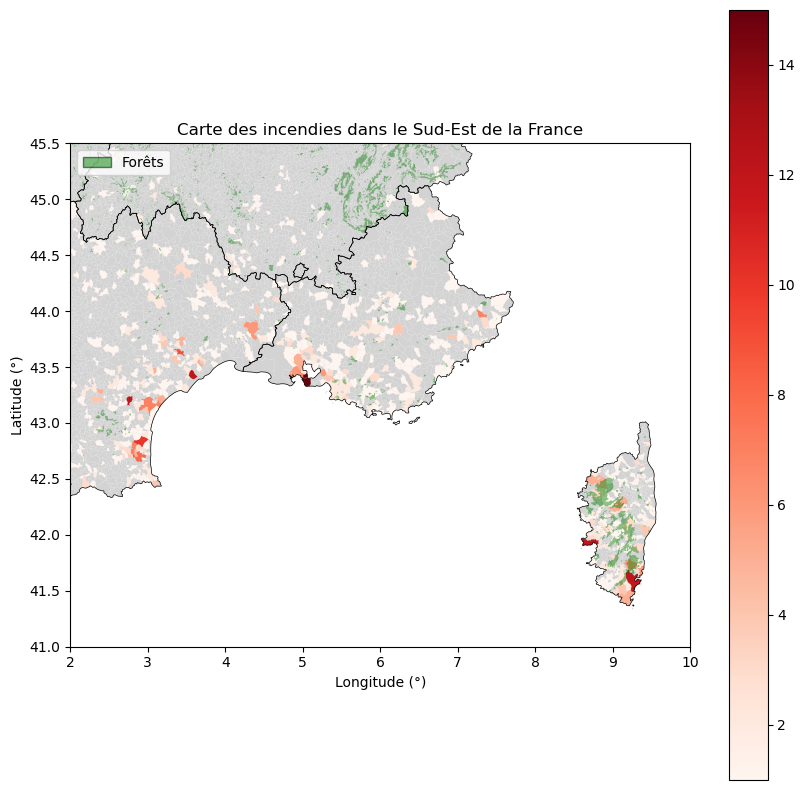

In [7]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

minx, miny, maxx, maxy = 2, 41, 10, 45.5  # Coordonnées approximatives pour le Sud-Est de la France

communes_metropole.plot(ax=ax, color='lightgrey')

regions.boundary.plot(ax=ax, color='black', linewidth=0.5)

merged_data[merged_data['Nombre_incendies'] > 0].plot(ax=ax, column='Nombre_incendies', legend=True, cmap='Reds')

forets.plot(ax=ax, color='green', alpha=0.5)

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

legend_elements = [Patch(facecolor='green', edgecolor='black', alpha=0.5, label='Forêts')]
ax.legend(handles=legend_elements, loc='upper left')


ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

plt.title('Carte des incendies dans le Sud-Est de la France')

plt.show()